In [ ]:
import pandas as pd

# 1. csv 파일 불러오기
df = pd.read_csv("강우량.csv 파일 경로 입력", encoding='cp949')

# 2. 지점명 컬럼 유니크한 값 확인
unique_places = df['지점명'].unique()

# 3. 개수와 함께 출력
print(f"총 고유 지점 수: {len(unique_places)}")
print("고유 지점명 목록:")
print(unique_places)

총 고유 지점 수: 57
고유 지점명 목록:
['독도' '주왕산' '천부' '태하' '평해' '영양' '온정' '옥산' '청하' '죽장' '선산' '의흥' '호미곶' '대덕'
 '성주' '황성' '고령' '청도' '부석' '예천' '구룡포' '수비' '마성' '예안' '하회' '공성' '김천' '군위'
 '가산' '칠곡' '신녕' '경산' '외동' '기계' '석포' '단북' '은척' '화서' '봉화읍' '현서' '이산' '동로'
 '길안' '하양' '화북' '산내' '금강송' '영덕읍' '소보' '청도금천' '지보' '감포' '소곡' '죽변' '팔공산'
 '토함산' '안동옥동']


## 지점정보로 위도 경도 추가하기

In [ ]:
import pandas as pd

# 1. 파일 불러오기
df = pd.read_csv("강우량.csv 파일 경로 입력", encoding='cp949')
hg = pd.read_csv("지점정보.csv 파일 경로 입력", encoding='cp949')

# 2. 날짜 형식 변환
df['일시'] = pd.to_datetime(df['일시'], errors='coerce')
hg['시작일'] = pd.to_datetime(hg['시작일'], errors='coerce')
hg['종료일'] = pd.to_datetime(hg['종료일'], errors='coerce')  # 종료일이 비어있으면 운영 중

# 3. 병합 (지점명 기준)
merged = pd.merge(df, hg[['지점명', '지점주소', '위도', '경도', '시작일', '종료일']], on='지점명', how='left')

# 4. 운영 중인 관측소 필터링
# 종료일이 NaT이면 현재까지 운영 중, 또는 df['일시']가 시작일 이후 종료일 이전이면 포함
valid_data = merged[
    (merged['일시'] >= merged['시작일']) &
    ((merged['종료일'].isna()) | (merged['일시'] <= merged['종료일']))
].copy()

# 5. 필요한 컬럼만 추출
result = valid_data[['일시', '일강수량(mm)', '지점명', '지점주소', '위도', '경도']]

# 6. 저장
result.to_csv('강우량_운영중_지점포함2022.csv', index=False, encoding='utf-8-sig')


## 위도 경도를  EPSG:5179로 변환 코드

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 1. 파일 불러오기
df = pd.read_csv("강우량.csv 파일경로 입력", encoding='cp949')
hg = pd.read_csv("지점정보.csv 파일경로 입력", encoding='cp949')

# 2. 날짜 형식 변환
df['일시'] = pd.to_datetime(df['일시'], errors='coerce')
hg['시작일'] = pd.to_datetime(hg['시작일'], errors='coerce')
hg['종료일'] = pd.to_datetime(hg['종료일'], errors='coerce')  # 종료일이 NaN이면 현재 운영 중

# 3. 병합 (지점명 기준)
merged = pd.merge(df, hg[['지점명', '지점주소', '위도', '경도', '시작일', '종료일']], on='지점명', how='left')

# 4. 운영 중인 관측소 필터링
valid_data = merged[
    (merged['일시'] >= merged['시작일']) &
    ((merged['종료일'].isna()) | (merged['일시'] <= merged['종료일']))
].copy()

# 5. EPSG:5179 변환 추가
# GeoDataFrame으로 변환
gdf = gpd.GeoDataFrame(
    valid_data,
    geometry=gpd.points_from_xy(valid_data['경도'], valid_data['위도']),
    crs='EPSG:4326'
)

# 좌표계 변환: EPSG 5179 (중부원점)
gdf_proj = gdf.to_crs(epsg=5179)

# 변환된 좌표 추가
gdf['변환경도'] = gdf_proj.geometry.x
gdf['변환위도'] = gdf_proj.geometry.y

# 6. 필요한 컬럼만 선택
result = gdf[['일시', '일강수량(mm)', '지점명', '지점주소', '위도', '경도', '변환위도', '변환경도']]

# 7. 저장
result.to_csv('강우량_운영중_지점포함_5179.csv', index=False, encoding='utf-8-sig')


## 폴리곤 형식에 데이터 넣기

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree

# 1. 읍면동 SHP 파일 읽기
gdf = gpd.read_file("폴리곤 형식의 csv 파일 경로 입력(LSMD_ADM_SECT_UMD_47_202505.shp)",encoding="cp949")

# 중심점 계산
gdf["centroid"] = gdf.geometry.centroid
gdf["centroid_x"] = gdf["centroid"].x
gdf["centroid_y"] = gdf["centroid"].y

# 2. 강수량 CSV 데이터 불러오기
rain_df = pd.read_csv("강우량_운영중_지점포함2022.csv 경로 입력")

# Point로 변환
rain_df["geometry"] = [Point(xy) for xy in zip(rain_df["경도"], rain_df["위도"])]
rain_gdf = gpd.GeoDataFrame(rain_df, geometry="geometry", crs="EPSG:4326")

# 좌표계 통일
rain_gdf = rain_gdf.to_crs(gdf.crs)

# 3. 최근접 거리 계산
centroids = list(zip(gdf["centroid_x"], gdf["centroid_y"]))
rain_coords = list(zip(rain_gdf.geometry.x, rain_gdf.geometry.y))

tree = cKDTree(rain_coords)
distances, indices = tree.query(centroids, k=1)

# 4. 가장 가까운 강수량 지점의 정보 추출
nearest_rain = rain_gdf.iloc[indices].reset_index(drop=True)
gdf = gdf.reset_index(drop=True)

# 5. 필요한 열만 추가
gdf["일시"] = nearest_rain["일시"]
gdf["일강수량"] = nearest_rain["일강수량(mm)"]
gdf["지점주소"] = nearest_rain["지점주소"]

# 6. 중심점 및 보조 컬럼 제거
gdf = gdf.drop(columns=["centroid", "centroid_x", "centroid_y"])

# 7. 결과를 SHP로 저장
gdf.to_file("eupmyeondong_with_rainfall.shp", encoding="cp949")


In [18]:
import geopandas as gpd
# SHP 파일 읽기 (encoding 생략하면 자동 감지 시도, 문제 있으면 cp949 명시)
shp_path = "eupmyeondong_with_rainfall.shp"
gdf = gpd.read_file(shp_path, encoding="cp949")  # 또는 euc-kr
# 컬럼명 확인
print("컬럼 목록:")
print(gdf.columns)

# 앞부분 몇 줄 확인
print("\n데이터 미리보기:")
print(gdf.head())

# 데이터 요약 (결측치, 타입 등)
print("\n요약 정보:")
print(gdf.info())

# 지오메트리 확인
print("\n지오메트리 타입 확인:")
print(gdf.geom_type.value_counts())


컬럼 목록:
Index(['EMD_CD', 'COL_ADM_SE', 'EMD_NM', 'SGG_OID', '일시', '일강수량', '지점주소',
       'geometry'],
      dtype='object')

데이터 미리보기:
     EMD_CD COL_ADM_SE EMD_NM  SGG_OID          일시  일강수량             지점주소  \
0  47940250      47940    울릉읍     1351  2021-10-13   0.0     경상북도 울릉군 천부리   
1  47940310      47940     서면     1370  2021-06-01   0.0     경상북도 울릉군 태하리   
2  47940320      47940     북면     1329  2021-10-13   0.0     경상북도 울릉군 천부리   
3  47111102      47110    대도동      187  2021-09-30  12.5  경상북도 포항시 북구 현내리   
4  47113115      47110    학잠동      186  2021-09-30  12.5  경상북도 포항시 북구 현내리   

                                            geometry  
0  MULTIPOLYGON (((548330.177 555258.162, 548331....  
1  MULTIPOLYGON (((536347.764 553552.794, 536348....  
2  MULTIPOLYGON (((545174.039 557338.169, 545165....  
3  POLYGON ((412271.109 381240.014, 412274.664 38...  
4  POLYGON ((410116.913 385276.045, 410119.632 38...  

요약 정보:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 526 ent

<Axes: >

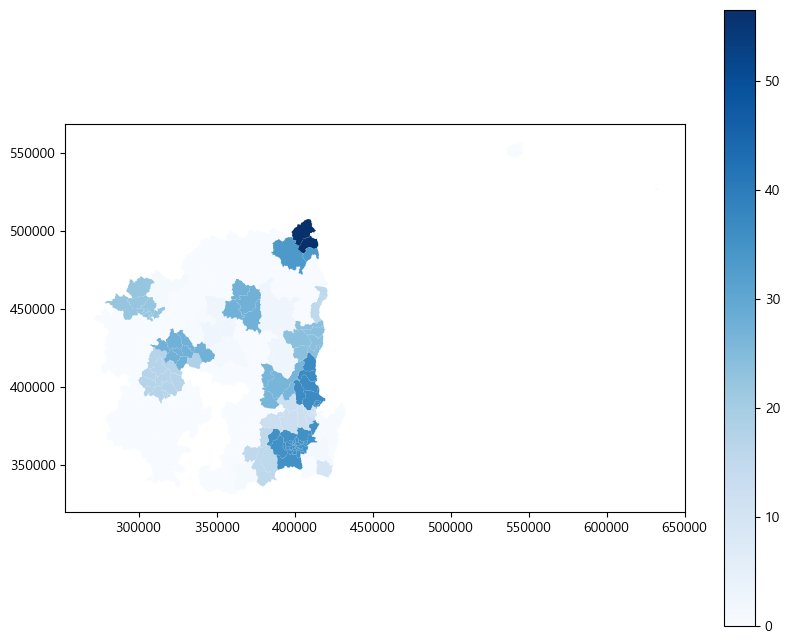

In [19]:
gdf.plot(column="일강수량", legend=True, figsize=(10, 8), cmap="Blues")
